# Online News Popularity project
paper https://repositorium.sdum.uminho.pt/bitstream/1822/39169/1/main.pdf

## First lets download the dataset

In [1]:
# imports
import pandas as pd
import subprocess
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.regression import LinearRegression

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when
from pyspark.sql.types import DoubleType


In [2]:
download = False
percorso_destinazione = "./dataset"
url = "https://archive.ics.uci.edu/static/public/332/online+news+popularity.zip"

if download:
    comando = ["wget", "-P", percorso_destinazione, url]
    subprocess.run(comando)
    
    comando_unzip = ["unzip", percorso_destinazione + '/' + url.split('/')[-1], "-d", percorso_destinazione]
    subprocess.run(comando_unzip)
    
    comando_directory = ['hdfs', 'dfs', '-mkdir', '-p', '/data']
    subprocess.run(comando_directory)
    
    comando = ['hdfs', 'dfs', 'put', 'percorso_destinazione + '/' + url.split('/')[-1]', '/data']
    subprocess.run(comando)
    

## initialize the HDFS and the resource manager

In [3]:
!hdfs namenode -format

namenode is running as process 3065.  Stop it first and ensure /tmp/hadoop-bda-namenode.pid file is empty before retry.


In [4]:
!/usr/local/hadoop-3.4.0/sbin/start-dfs.sh

Starting namenodes on [localhost]
localhost: namenode is running as process 3065.  Stop it first and ensure /tmp/hadoop-bda-namenode.pid file is empty before retry.
Starting datanodes
localhost: datanode is running as process 3206.  Stop it first and ensure /tmp/hadoop-bda-datanode.pid file is empty before retry.
Starting secondary namenodes [bda-VirtualBox]
bda-VirtualBox: secondarynamenode is running as process 3415.  Stop it first and ensure /tmp/hadoop-bda-secondarynamenode.pid file is empty before retry.


In [5]:
!/usr/local/hadoop-3.4.0/sbin/start-yarn.sh

Starting resourcemanager
Starting nodemanagers


### copy the data into HDFS

In [6]:
comando_directory = ['hdfs', 'dfs', '-mkdir', '-p', '/data']
subprocess.run(comando_directory)

comando = ['hdfs', 'dfs', '-put', percorso_destinazione + '/OnlineNewsPopularity/OnlineNewsPopularity.csv', '/data']
subprocess.run(comando)
    

put: `/data/OnlineNewsPopularity.csv': File exists


CompletedProcess(args=['hdfs', 'dfs', '-put', './dataset/OnlineNewsPopularity/OnlineNewsPopularity.csv', '/data'], returncode=1)

## initialize the spark session

In [7]:
spark = SparkSession.builder.appName("ONP")\
        .config("spark.sql.debug.maxToStringFields", "1000")\
        .master('local[*]')\
        .getOrCreate()

25/04/06 11:16:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Data analysis

In [8]:
path = "hdfs://localhost:9000/data/OnlineNewsPopularity.csv" # percorso_destinazione + '/OnlineNewsPopularity/OnlineNewsPopularity.csv'
df = spark.read.option("header", True).option("inferSchema", True).csv(path)
print(f"Number of samples: {df.count()}")

Number of samples: 39644


In [9]:
df.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: do

In [10]:
high_val_features = []
types = dict(df.dtypes)
for i in range(len(df.columns)//5):
    stats = df.describe(df.columns[5*i:(i+1)*5])
    stats.show()
    for col in df.columns[5*i:(i+1)*5]:
        max_value = stats.filter(stats["summary"] == "max").select(col).collect()[0][0]
        if types[col] in ['int','double'] and float(max_value) > 1000:
            high_val_features.append(col)

+-------+--------------------+------------------+------------------+------------------+------------------+
|summary|                 url|         timedelta|    n_tokens_title|  n_tokens_content|   n_unique_tokens|
+-------+--------------------+------------------+------------------+------------------+------------------+
|  count|               39644|             39644|             39644|             39644|             39644|
|   mean|                NULL|354.53047119362327|10.398748864897588|  546.514731106851|0.5482157168486088|
| stddev|                NULL| 214.1637671697689|2.1140368083035197|471.10750794805506| 3.520708331241112|
|    min|http://mashable.c...|               8.0|               2.0|               0.0|               0.0|
|    max|http://mashable.c...|             731.0|              23.0|            8474.0|             701.0|
+-------+--------------------+------------------+------------------+------------------+------------------+



+-------+------------------+-------------------------+------------------+------------------+-----------------+
|summary|  n_non_stop_words| n_non_stop_unique_tokens|         num_hrefs|    num_self_hrefs|         num_imgs|
+-------+------------------+-------------------------+------------------+------------------+-----------------+
|  count|             39644|                    39644|             39644|             39644|            39644|
|   mean|0.9964685654578603|       0.6891753940079369|10.883689839572192|3.2936383815962063|4.544142871556856|
| stddev| 5.231230945149074|       3.2648163548136098|11.332017376010876| 3.855141145374438|8.309433519603706|
|    min|               0.0|                      0.0|               0.0|               0.0|              0.0|
|    max|            1042.0|                    650.0|             304.0|             116.0|            128.0|
+-------+------------------+-------------------------+------------------+------------------+-----------------+



We do not have missing values so we do not have to deal with such a problem!

some columns need to be removed 
- url          does not provide useful informations
- timedelta    does not provide useful informations


### correlations

In [11]:
numeric_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double']]

In [12]:
corr = df.select(numeric_cols).toPandas().corr()

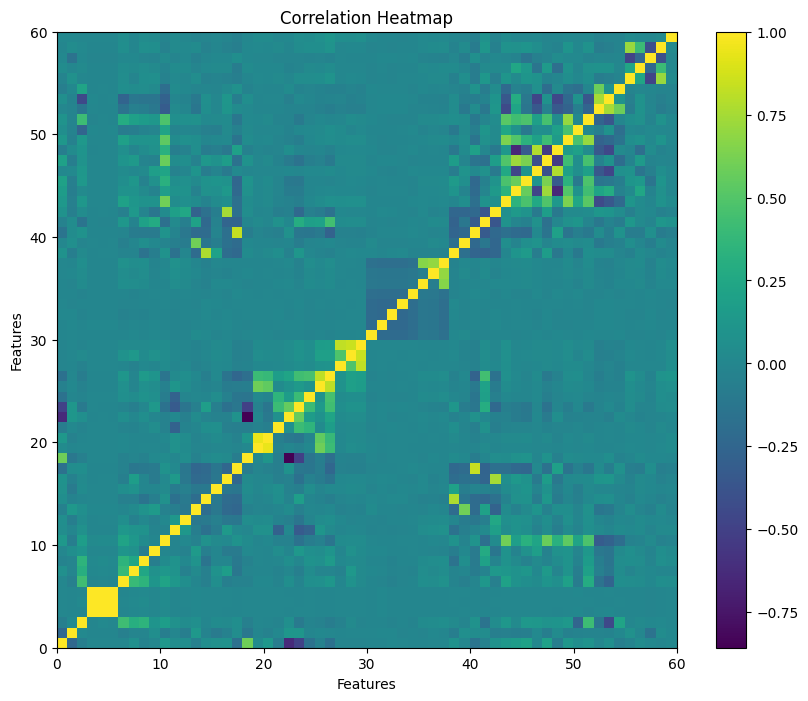

In [13]:
heatfig = plt.figure(figsize=(10, 8))
plt.pcolor(corr)

plt.colorbar()
plt.title("Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

heatfig.savefig('imgs/correlation.png', bbox_inches='tight')


### boxplot

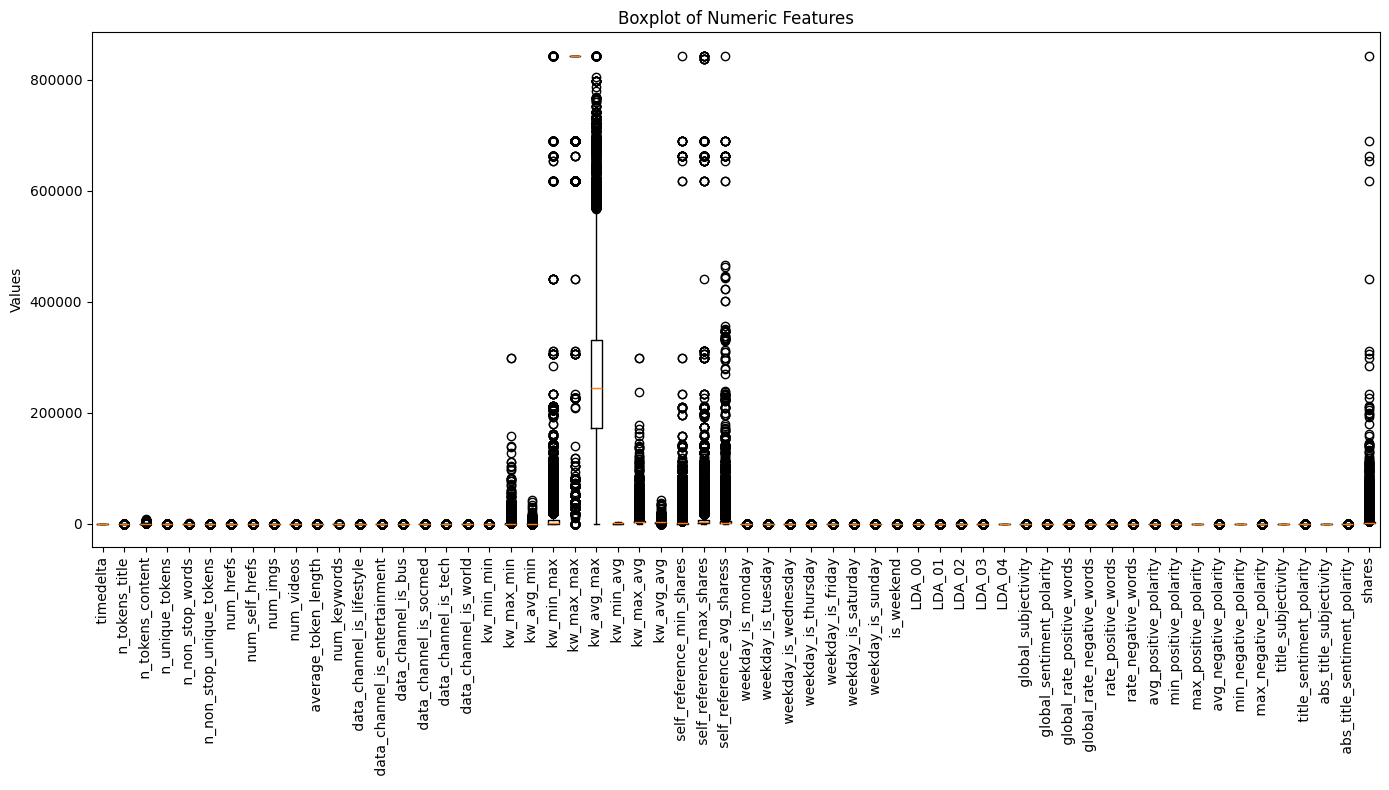

In [14]:
# Convert the DataFrame to pandas
pd = df.select(numeric_cols).toPandas()

plt.figure(figsize=(14, 8))
plt.boxplot(pd.values)
plt.xticks(range(1, len(numeric_cols)+1), numeric_cols, rotation=90)
plt.title('Boxplot of Numeric Features')
plt.ylabel('Values')

plt.tight_layout()
plt.savefig('imgs/boxplots')
plt.show()

### observation
Since many features are already in the range 0..1, i choosed to normalize the data. Hovewer it could make sense to apply a log transformation before that. lets show the data distribution of the features with high values

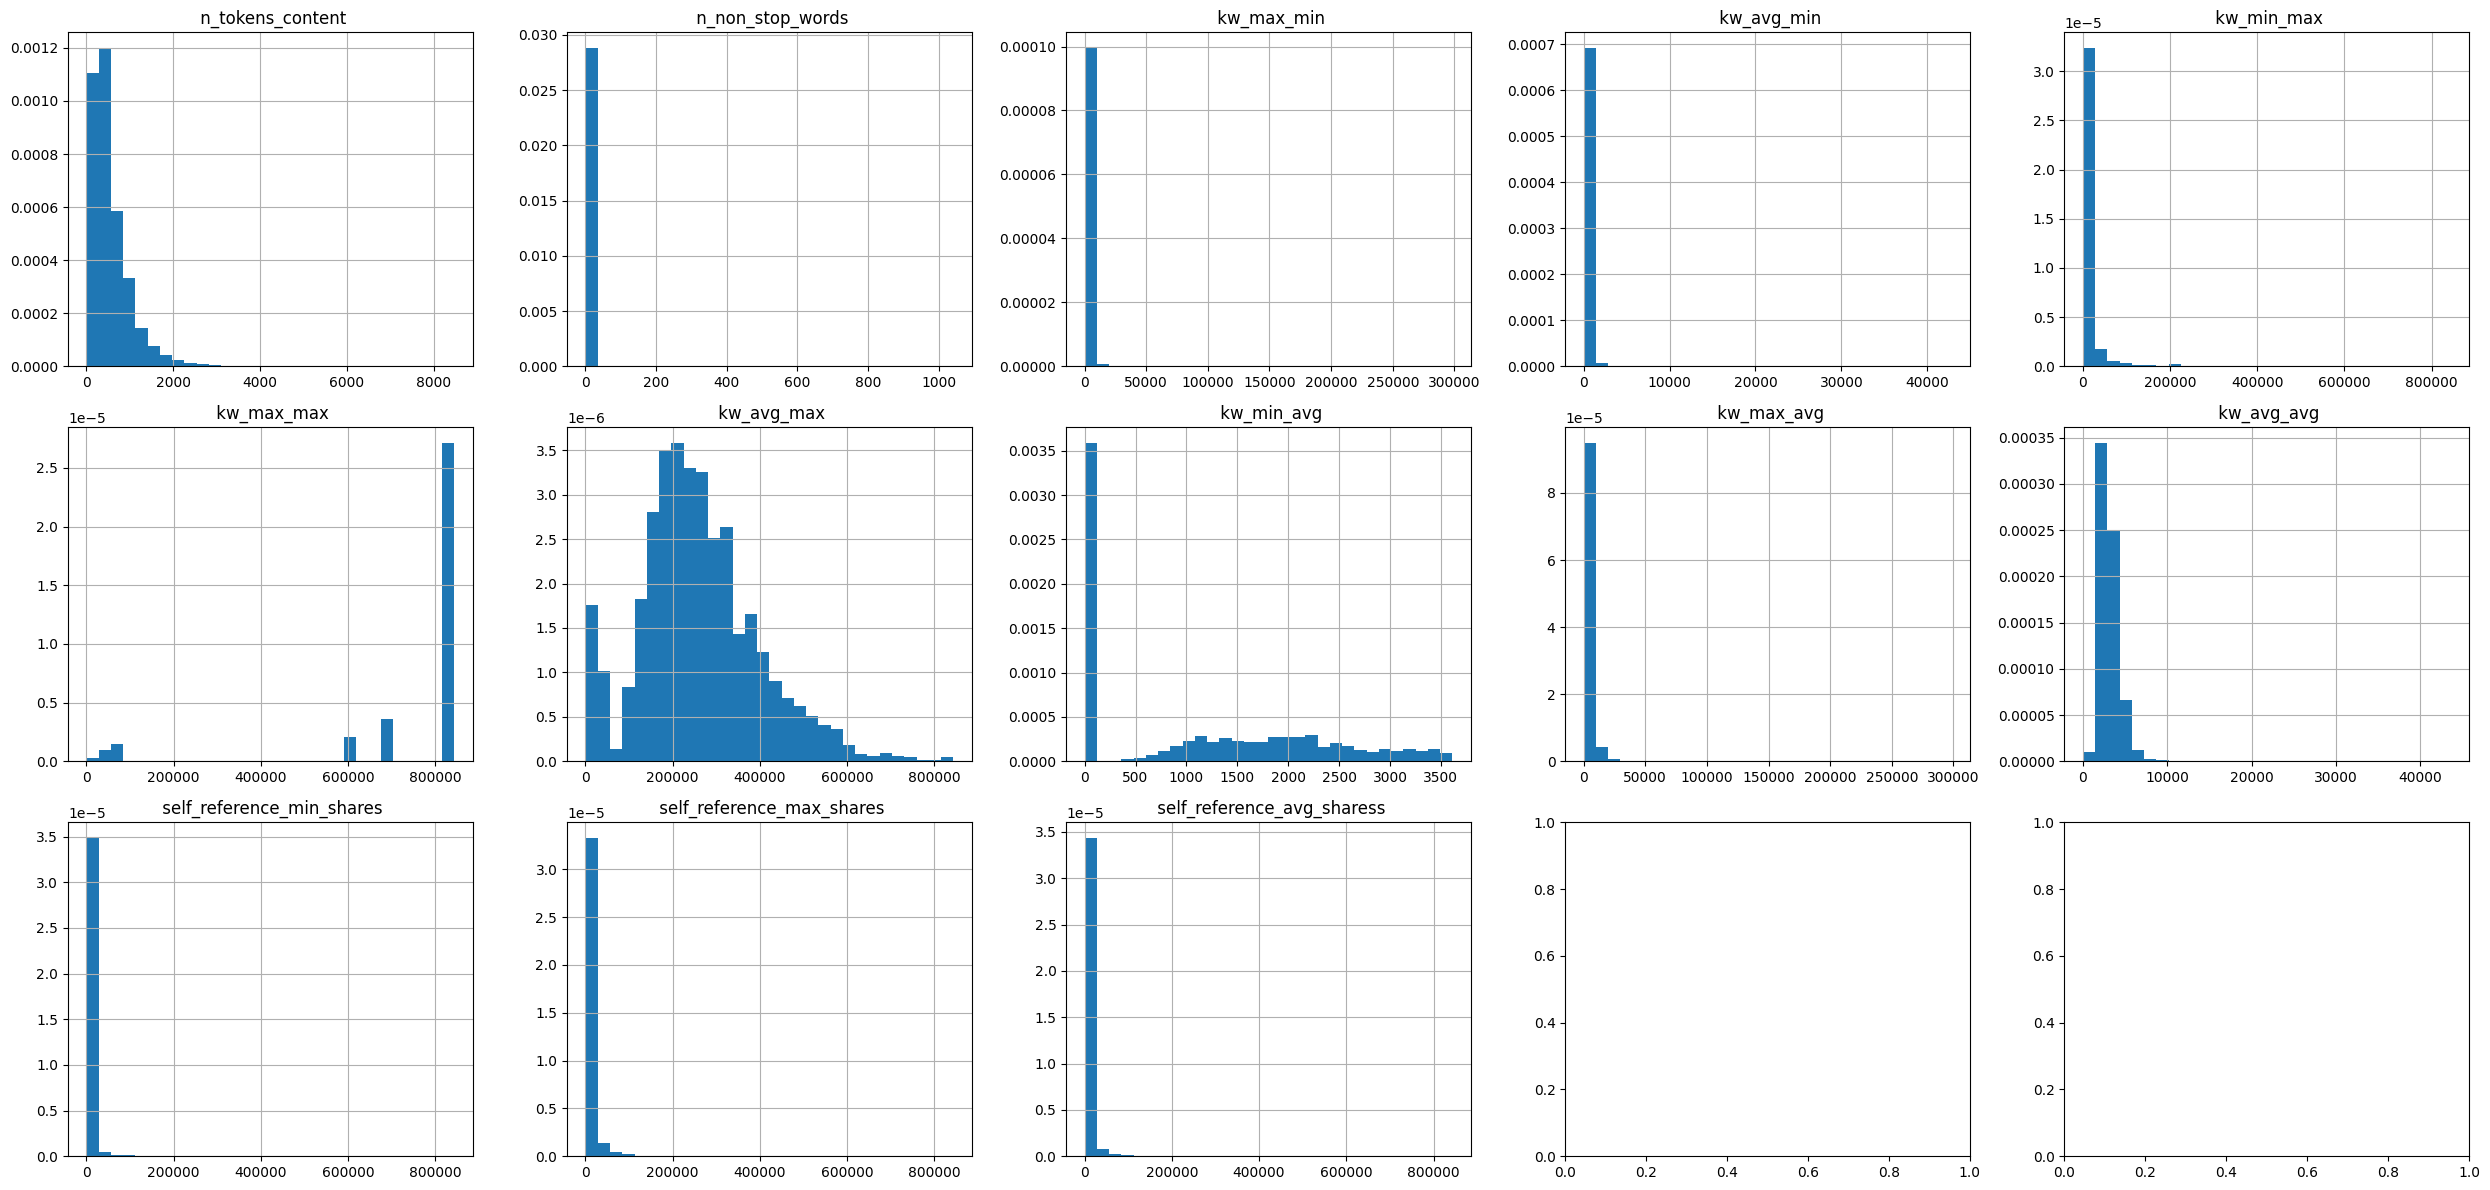

In [15]:
# original high vals distributions
n_cols = 5
n_rows = len(high_val_features)//n_cols + 1
fig, axes = plt.subplots(nrows = n_rows,
                           ncols= n_cols,
                            figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(high_val_features):
    vals = df.select(col).toPandas()[col].values 
    ax = axes[i]
    ax.hist(vals, density=True, bins=30)
    ax.grid(':')
    ax.set_title(col)

plt.tight_layout()
plt.savefig('imgs/high_vals_distributions')
plt.show()

### Those distributions are too difficult to capture, so we apply a non linear transformation such the log

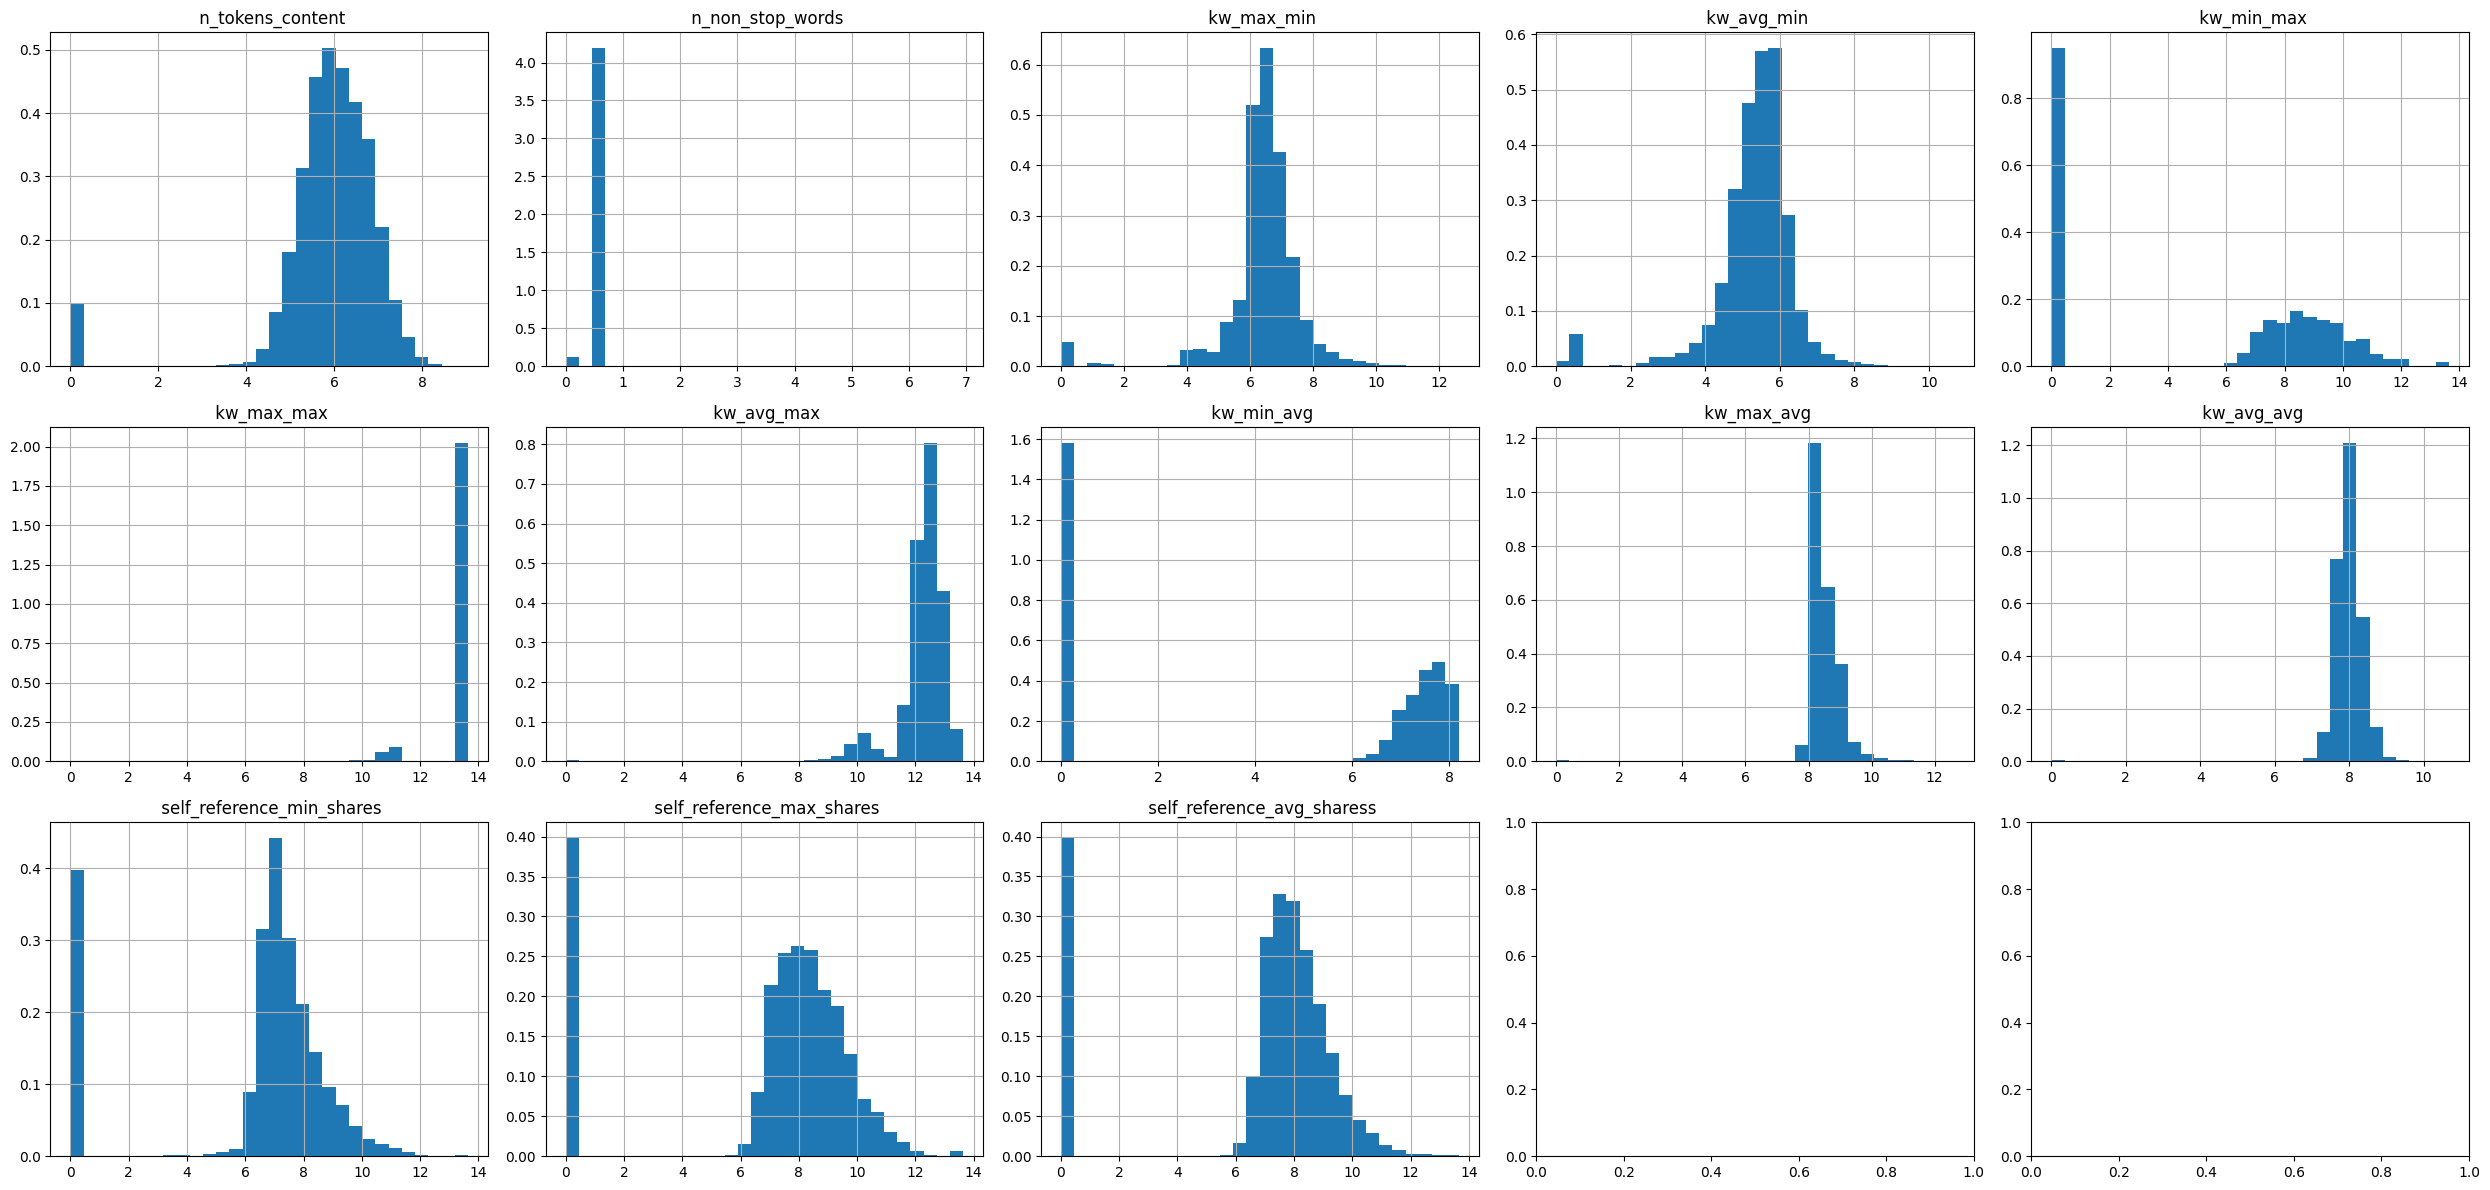

In [16]:
# transformed distributions
n_cols = 5
n_rows = len(high_val_features)//n_cols + 1
fig, axes = plt.subplots(nrows = n_rows,
                           ncols= n_cols,
                            figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(high_val_features):
    vals = df.select(col).toPandas()[col].values
    vals = np.log(abs(vals)+1)
    ax = axes[i]
    ax.hist(vals, density=True, bins=30)
    ax.grid(':')
    ax.set_title(col)

plt.tight_layout()
plt.savefig('imgs/high_vals_distributions_log_transformed')
plt.show()

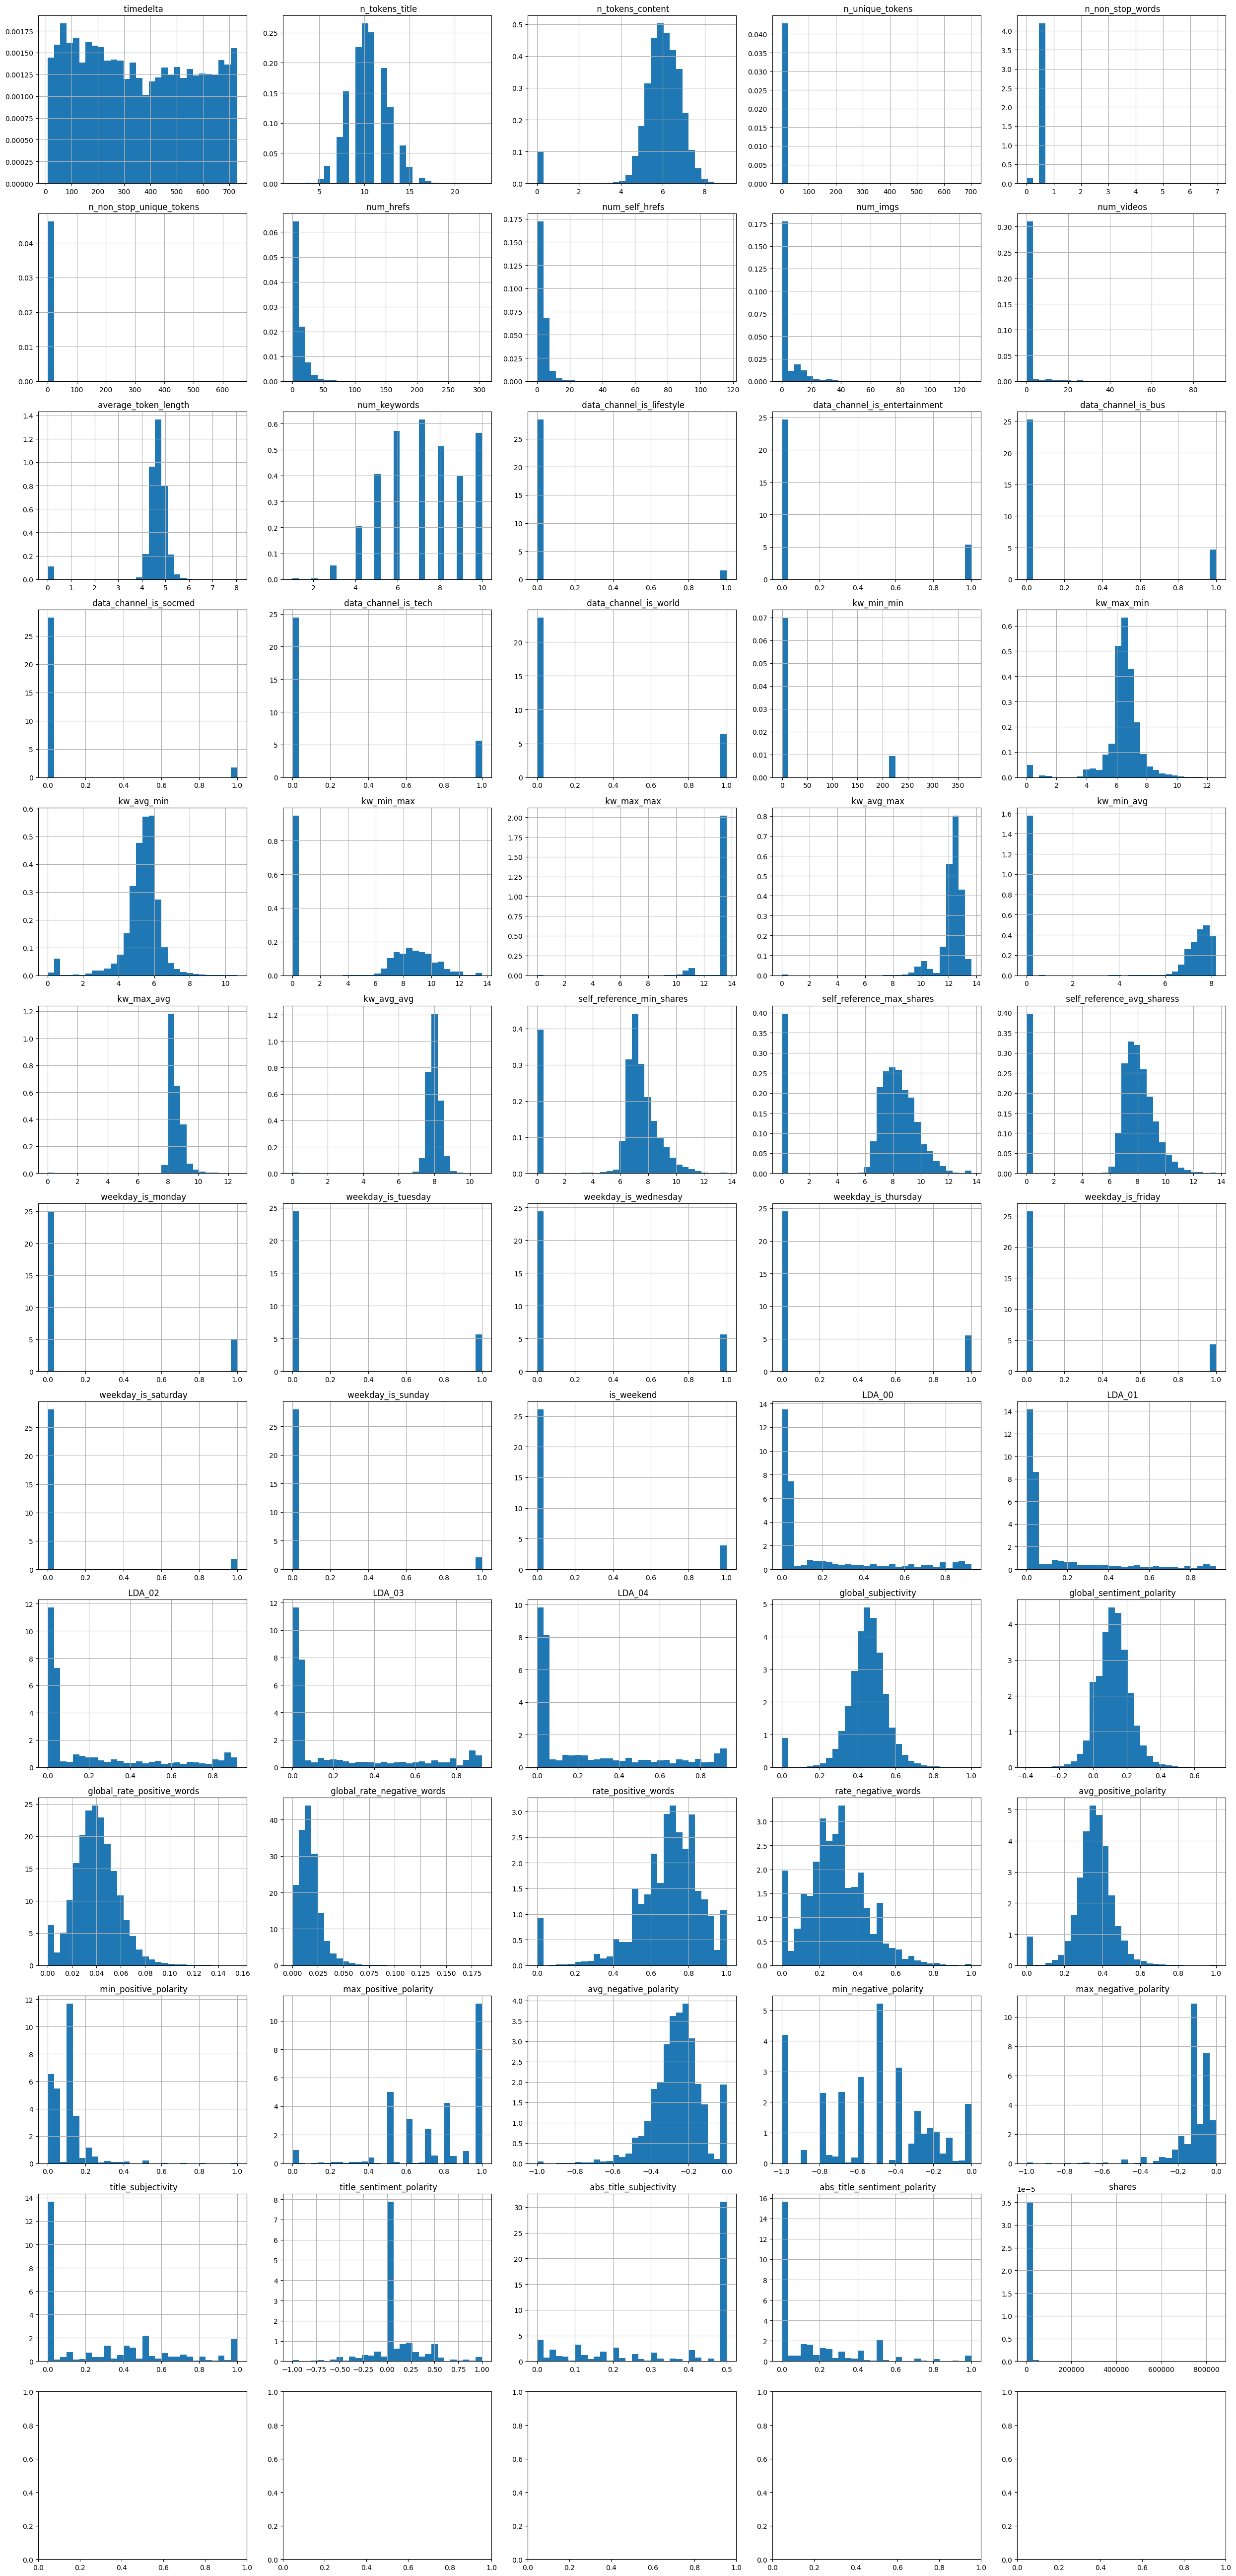

In [17]:
# all distributions
n_cols = 5
n_rows = len(numeric_cols)//n_cols + 1
fig, axes = plt.subplots(nrows = n_rows,
                           ncols= n_cols,
                            figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    vals = df.select(col).toPandas()[col].values
    if col in high_val_features:
        vals = np.log(abs(vals)+1)
    ax = axes[i]
    ax.hist(vals, density=True, bins=30)
    ax.grid(':')
    ax.set_title(col)

plt.tight_layout()
plt.savefig('imgs/final_distributions')
plt.show()

## pipeline
the pipeline consists of:

    - remove unused columns
    - apply log where needed
    - vector assembler
    - min max scaler
    - create binary target

### defining ColumnFilter class


In [18]:
class ColumnFilter(Transformer):
    def __init__(self, columns_to_keep):
        super().__init__()
        self.columns_to_keep = columns_to_keep

    def _transform(self, dataframe):
        return dataframe.select(self.columns_to_keep)
     

### defining LogTransf class

In [19]:
class LogTransf(Transformer):
    def __init__(self, columns):
        super().__init__()
        self.columns = columns

    def _transform(self, dataframe):
        for col in self.columns:
            # Apply the log transformation: sign * log(abs(col) + 1)
            dataframe = dataframe.withColumn(
                col, 
                F.sign(dataframe[col]) * F.log(F.abs(dataframe[col]) + 1)
            )
        return dataframe


### creating the binary target

In [20]:
class BinaryTarget(Transformer):
    def __init__(self, target, thr):
        super().__init__()
        self.target = target 
        self.thr = thr

    def _transform(self, dataframe):
        # If the value is >= threshold, set it to 1, otherwise set it to 0
        dataframe = dataframe.withColumn(
            self.target, 
            F.when(dataframe[self.target] >= self.thr, 1).otherwise(0)
        )
        return dataframe

In [21]:
# numeric_cols[1:-1]
# shares

In [22]:
target = numeric_cols[-1] # shares
cF = ColumnFilter(numeric_cols[1:])
lT = LogTransf(high_val_features)
assembler = VectorAssembler(inputCols=numeric_cols[1:-1], # do not pass the target
                            outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')
targetTransformer = BinaryTarget(target,
                                  1400   # as indicated in the original paper
                              )

pipeline = Pipeline(stages=[cF, lT, assembler, scaler, targetTransformer]) 
prepared_df = pipeline.fit(df).transform(df)   

## define and train different ml models

### create train val split

In [23]:
seed = 69
train, val = prepared_df.randomSplit([0.7, 0.3], seed = seed)

In [24]:
# for each model fit, transform, evaluate models
models_dict = {
    'linearRegressor' : {'function':LinearRegression,
                        'args' : {'featuresCol':'scaledFeatures',
                                  'labelCol':target,
                                 },
                         'varing_pars' : {
                            'regParam' : [.000001,.00001,.0001,.001,.01,.1,1.], # control the regularization strength
                         },
                        'accuracy': [],
                         'f1':[]},
    'mlp' : {'function':MultilayerPerceptronClassifier,
                        'args' : {'featuresCol':'scaledFeatures',
                                  'labelCol':target,
                                 },
                         'varing_pars' : {
                            'layers':[[len(numeric_cols[1:-1]), 16, 32, 16, 2],
                                         [len(numeric_cols[1:-1]), 32, 64, 32, 2],
                                         [len(numeric_cols[1:-1]), 64, 64, 64, 2],
                                     ],
                         },
                        'accuracy': [],
                         'f1':[]},
    'decisionTree' : {'function':DecisionTreeClassifier,
                        'args' : {'featuresCol':'scaledFeatures',
                                  'labelCol':target,
                                 },
                         'varing_pars' : {
                            'impurity':['gini', 'entropy'],
                         },
                        'accuracy': [],
                         'f1':[]},
    'NaiveBayes' : {'function':NaiveBayes,
                        'args' : {'featuresCol':'scaledFeatures',
                                  'labelCol':target,
                                  'modelType':'multinomial',
                                 },
                         'varing_pars' : {
                            'smoothing':[0., 0.1, 0.5, ],
                         },
                        'accuracy': [],
                         'f1':[]},
    'randomForest' : {'function':RandomForestClassifier,
                        'args' : {'featuresCol':'scaledFeatures',
                                  'labelCol':target,
                                  'seed':seed,
                                 },
                         'varing_pars' : {
                            'impurity':['gini', 'entropy'],
                         },
                        'accuracy': [],
                         'f1':[]},
}

In [25]:
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol=target, 
    predictionCol="prediction", 
    metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol=target, 
    predictionCol="prediction", 
    metricName="f1"
)

for model_name in models_dict.keys():
    if 'varing_pars' in models_dict[model_name].keys():
        varing_pars_key = list(models_dict[model_name]['varing_pars'].keys())[0]
        for varing_par in models_dict[model_name]['varing_pars'][varing_pars_key]:
        
            args_dict = models_dict[model_name]['args']
            args_dict[varing_pars_key] = varing_par
            
            model = models_dict[model_name]['function'](** args_dict)
            fitted_model = model.fit(train)
            
            predictions = fitted_model.transform(val)
            predictions = predictions.withColumn("prediction", when(predictions["prediction"] > 0.5, 1).otherwise(0).cast(DoubleType()))
            
            accuracy = evaluator_accuracy.evaluate(predictions)
            f1 = evaluator_f1.evaluate(predictions)
            models_dict[model_name]['accuracy'].append(accuracy)
            models_dict[model_name]['f1'].append(f1)
    else:
        args_dict = models_dict[model_name]['args']
        
        model = models_dict[model_name]['function'](** args_dict)
        fitted_model = model.fit(train)
        
        predictions = fitted_model.transform(val)
        predictions = predictions.withColumn("prediction", when(predictions["prediction"] > 0.5, 1).otherwise(0).cast(DoubleType()))
        
        accuracy = evaluator_accuracy.evaluate(predictions)
        f1 = evaluator_f1.evaluate(predictions)
        models_dict[model_name]['accuracy'].append(accuracy)
        models_dict[model_name]['f1'].append(f1)


25/04/06 11:17:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

## Results

In [26]:
for model_name in models_dict.keys():
    accuracy = models_dict[model_name]['accuracy']
    f1 = models_dict[model_name]['f1']
    print(f"model: {model_name}\n\taccuracy: {accuracy}, \n\t f1: {f1}")

model: linearRegressor
	accuracy: [0.6448707256046705, 0.6450375312760633, 0.6449541284403669, 0.6460383653044204, 0.6442869057547956, 0.6376980817347789, 0.6272727272727273], 
	 f1: [0.6433495507423963, 0.643533682649027, 0.6434124257662289, 0.6444039431936444, 0.6424991523063824, 0.6346801440355314, 0.6164588188319313]
model: mlp
	accuracy: [0.6396163469557965, 0.6381984987489575, 0.6402835696413678], 
	 f1: [0.638102125092506, 0.636501441173126, 0.6384116648657719]
model: decisionTree
	accuracy: [0.6321100917431193, 0.6299416180150125], 
	 f1: [0.6322679042992418, 0.6301015816544413]
model: NaiveBayes
	accuracy: [0.6197664720600501, 0.6197664720600501, 0.6197664720600501], 
	 f1: [0.6148919274733113, 0.6148919274733113, 0.6148919274733113]
model: randomForest
	accuracy: [0.6360300250208507, 0.6360300250208507], 
	 f1: [0.6290646892483857, 0.628833120303099]


/tmp/ipykernel_4249/565178332.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_means, ax=ax[0], palette="Blues_d")
/tmp/ipykernel_4249/565178332.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_means, ax=ax[1], palette="Blues_d")


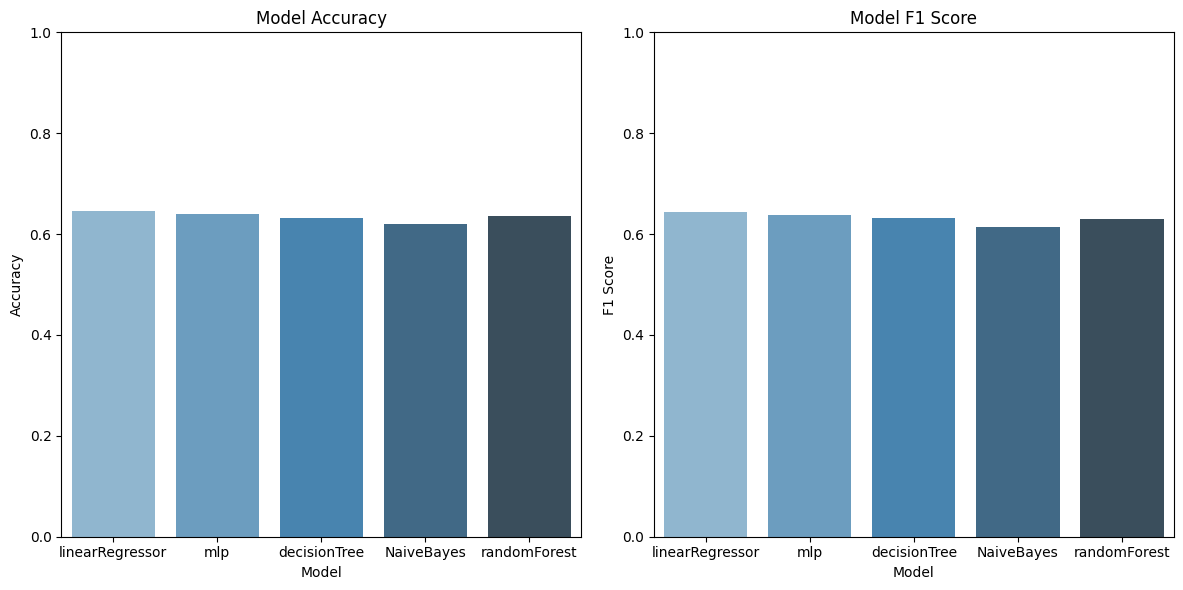

In [27]:
# plotting results
model_names = list(models_dict.keys())
accuracy_means = [np.max(models_dict[model]['accuracy']) for model in model_names]
f1_means = [np.max(models_dict[model]['f1']) for model in model_names]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=model_names, y=accuracy_means, ax=ax[0], palette="Blues_d")
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1)

sns.barplot(x=model_names, y=f1_means, ax=ax[1], palette="Blues_d")
ax[1].set_title('Model F1 Score')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 Score')
ax[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('imgs/scores')
plt.show()